In [431]:
# pandas data structures tutorial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [432]:
from sklearn.metrics import log_loss
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def get_linear_model(beta_0, beta_1):
    def model(xs):
        return np.array(list(map(sigmoid, beta_0 + beta_1 * xs)))
    return model

def get_costs_function(X, y, get_model):
    def get_costs_for(beta_0, beta_1):
        model = get_model(beta_0, beta_1)
        loss = log_loss(y, model(X), normalize=False)
        # loss = -np.sum(y * np.log(model(X)) + (1 - y) * np.log(1 - model(X)))
        reg_loss = 0.5 * (beta_0*beta_0+beta_1*beta_1)
        return loss + reg_loss
    return get_costs_for


def plot_J(ax, bbeta_0, bbeta_1, X, y, bbeta_0_deltas = None, bbeta_1_deltas = None, beta_delta = 0, get_model = None):

    cost_function = get_costs_function(X, y, get_model)

    bbeta_0_deltas = bbeta_0_deltas or []
    bbeta_1_deltas = bbeta_1_deltas or []

    pre = 64
    if len(bbeta_0_deltas) > 0:
        beta_delta = max(*bbeta_0_deltas, beta_delta)
    if len(bbeta_1_deltas) > 0:
        beta_delta = max(*bbeta_1_deltas, beta_delta)

    beta_0s, beta_1s = np.meshgrid(
        np.linspace(bbeta_0-beta_delta, bbeta_0+beta_delta, pre),
        np.linspace(bbeta_1-beta_delta, bbeta_1+beta_delta, pre)
    )

    costs = np.empty([pre, pre])

    for i in range(0, pre):
        for j in range(0, pre):
            costs[j, i] = cost_function(beta_0s[j, i], beta_1s[j, i])

    ax.plot_surface(beta_0s, beta_1s, costs, cmap=cm.jet, alpha=0.5)

    steps_x, steps_y, steps_z = [], [], []
    for bbeta_0_delta, bbeta_1_delta in zip(bbeta_0_deltas, bbeta_1_deltas):
        ebeta_0, ebeta_1 = bbeta_0 - bbeta_0_delta, bbeta_1 - bbeta_1_delta
        steps_x.append(ebeta_0)
        steps_y.append(ebeta_1)
        steps_z.append(cost_function(ebeta_0, ebeta_1))
        y_bottom = ax.get_zlim()[0]
        if bbeta_0_delta != bbeta_0_deltas[-1]:
            ax.plot(xs=[ebeta_0, ebeta_0], ys=[ebeta_1, ebeta_1], zs=[cost_function(ebeta_0, ebeta_1), y_bottom], c='orange', alpha=0.2)
        else:
            ax.plot(xs=[ebeta_0, ebeta_0], ys=[ebeta_1, ebeta_1], zs=[cost_function(ebeta_0, ebeta_1), y_bottom], c='green')

    ax.plot(xs=steps_x, ys=steps_y, zs=steps_z, c='red')

    ax.set_xlabel('beta_0')
    ax.set_ylabel('beta_1')
    ax.set_zlabel('cost')

    # ax.axes.xaxis.set_ticks([])
    # ax.axes.yaxis.set_ticks([])
    # ax.axes.zaxis.set_ticks([])

In [433]:
def plot_J_contour(ax, bbeta_0, bbeta_1, X, y, bbeta_0_deltas = None, bbeta_1_deltas = None, beta_delta = 0, get_model = None):

    cost_function = get_costs_function(X, y, get_model)

    bbeta_0_deltas = bbeta_0_deltas or []
    bbeta_1_deltas = bbeta_1_deltas or []

    pre = 64
    if len(bbeta_0_deltas) > 0:
        beta_delta = max(*bbeta_0_deltas, beta_delta)
    if len(bbeta_1_deltas) > 0:
        beta_delta = max(*bbeta_1_deltas, beta_delta)

    beta_0s, beta_1s = np.meshgrid(
        np.linspace(bbeta_0-beta_delta, bbeta_0+beta_delta, pre),
        np.linspace(bbeta_1-beta_delta, bbeta_1+beta_delta, pre)
    )

    costs = np.empty([pre, pre])

    for i in range(0, pre):
        for j in range(0, pre):
            costs[j, i] = cost_function(beta_0s[j, i], beta_1s[j, i])

    ax.contour(beta_0s, beta_1s, costs, cmap=cm.jet)

    steps_x, steps_y = [], []
    for bbeta_0_delta, bbeta_1_delta in zip(bbeta_0_deltas, bbeta_1_deltas):
        ebeta_1, ebeta_2 = bbeta_0 - bbeta_0_delta, bbeta_1 - bbeta_1_delta
        steps_x.append(ebeta_1)
        steps_y.append(ebeta_2)
        if bbeta_0_delta != bbeta_0_deltas[-1]:
            ax.scatter(ebeta_1, ebeta_2, c='orange', alpha=0.2)
        else:
            ax.scatter(ebeta_1, ebeta_2, c='green')

    ax.plot(steps_x, steps_y, c='red')

    ax.set_xlabel('beta_0')
    ax.set_ylabel('beta_1')

    # ax.axes.xaxis.set_ticks([])
    # ax.axes.yaxis.set_ticks([])


In [434]:
out_dir = os.path.join(os.getcwd(), "../../out/classification")

In [435]:
df = pd.read_csv('data/iris.csv').rename(columns={
    'sepal length': 'sepal length (cm)',
    'sepal width': 'sepal width (cm)',
    'petal length': 'petal length (cm)',
    'petal width': 'petal width (cm)',
})

df['setosa'] = df['name'].apply(lambda name: 'Setosa' if name == 'Setosa' else 'Other')

In [436]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

order = ['Other', 'Setosa']
X_norm = StandardScaler().fit_transform(PCA().fit_transform(StandardScaler().fit_transform(df[['petal width (cm)']])))
y = OrdinalEncoder(categories=[order]).fit_transform(df[['setosa']]).reshape(-1,)

In [437]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000000, tol=1e-20)
model.fit(X_norm, y)
bbeta_0 = model.intercept_[0]
bbeta_1 = model.coef_[0][0]
print(bbeta_0, bbeta_1)

-2.3747106887939093 -4.05680694791129


In [438]:
bbeta_0_deltas = list(map(lambda x: x / 5, [5, 3.5, 2.7, 1.9, 1.2, 0]))
bbeta_1_deltas = list(map(lambda x: x / 5, [-5, -4.0, -3.0, -2.0, -1.0, 0]))

In [439]:
beta_delta = max(bbeta_0_deltas + bbeta_1_deltas)

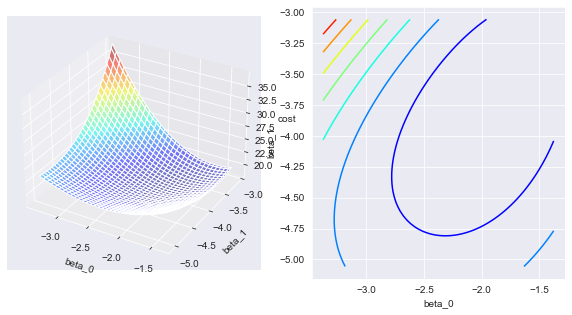

In [440]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_J(ax, bbeta_0, bbeta_1, X_norm, y, beta_delta=beta_delta, get_model=get_linear_model)
ax2d = fig.add_subplot(1, 2, 2)
ax2d.set_xlim(ax.get_xlim())
ax2d.set_ylim(ax.get_ylim())
# ax.set_zscale('log')
plot_J_contour(ax2d, bbeta_0, bbeta_1, X_norm, y, beta_delta=beta_delta, get_model=get_linear_model)
plt.savefig(os.path.join(out_dir, 'gradient_descent_cost_function.png'))
plt.show()

In [441]:
def plot_model_1d(beta_0, beta_1, X, y, ax):

    threshold = -beta_0 / beta_1 # b0 + b1 * x1 == 0 => x1 = -bo / b1

    df = pd.DataFrame({'petal width (std)': X[:, 0]})
    df['const'] = 0
    df['setosa'] = y

    # sns.stripplot(data=df, x='petal width (std)', y='const', hue='setosa', jitter=False, palette=dict(zip(
    #     order,
    #     sns.color_palette(),
    # )), ax = ax)

    # axvspan not working with seaborn? => Take matplotlib instead
    t = X[y == 'Setosa', 0]
    ax.scatter(t, [0] * t.shape[0], color=sns.color_palette()[1])
    t = X[y == 'Other', 0]
    ax.scatter(t, [0] * t.shape[0], color=sns.color_palette()[0])

    ax.axvspan(threshold, df['petal width (std)'].max(), facecolor=sns.color_palette()[0], alpha=0.25, label=order[0])
    ax.axvspan(df['petal width (std)'].min(), threshold, facecolor=sns.color_palette()[1], alpha=0.25, label=order[1])

    ax.plot([threshold, threshold], [-1, 1], color='green')

def plot_gradient_descent(bbeta_0, bbeta_1, X, y, bbeta_0_deltas = None, bbeta_1_deltas = None, beta_delta = 0, get_model = None):
    """
    WARNING: This function does only visualize how gradient descent works.
    The actual plots are a lie :D and do not depend on each other.
    """

    bbeta_0_deltas = bbeta_0_deltas or []
    bbeta_1_deltas = bbeta_1_deltas or []

    fig = plt.figure(figsize=(15, 5), facecolor='white')
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    plot_J(ax, bbeta_0, bbeta_1, X, y, bbeta_0_deltas, bbeta_1_deltas, beta_delta, get_model)
    ax_contour = fig.add_subplot(1, 3, 2)
    ax_contour.set_xlim(ax.get_xlim())
    ax_contour.set_ylim(ax.get_ylim())
    plot_J_contour(ax_contour, bbeta_0, bbeta_1, X, y, bbeta_0_deltas, bbeta_1_deltas, beta_delta, get_model)
    ax = fig.add_subplot(1, 3, 3)

    plot_model_1d(bbeta_0 - bbeta_0_deltas[-1], bbeta_1 - bbeta_1_deltas[-1], X, df['setosa'], ax)

    # for bbeta_0_delta, bbeta_1_delta in zip(bbeta_0_deltas, bbeta_1_deltas):
    #     model = get_model(bbeta_0 - bbeta_0_delta, bbeta_1 - bbeta_1_delta)
    #     sx = np.sort(X, axis=0)
    #     if bbeta_0_delta != bbeta_0_deltas[-1]:
    #         ax.plot(sx, model(sx), c='orange', alpha=0.2)
    #     else:
    #         ax.plot(sx, model(sx), c='green')

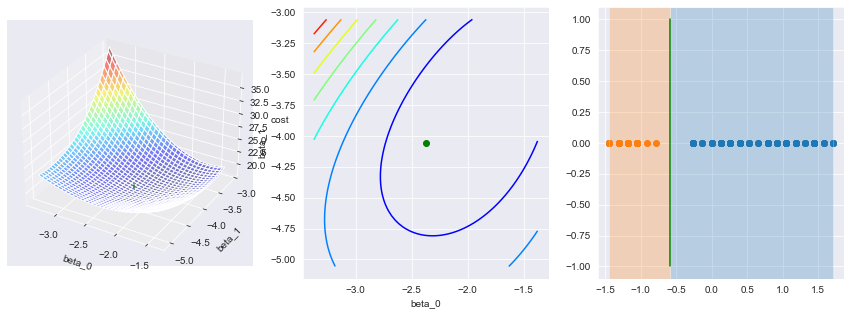

In [442]:
plot_gradient_descent(bbeta_0, bbeta_1, X_norm, y, [0], [0], beta_delta, get_linear_model)
plt.savefig(os.path.join(out_dir, 'gradient_descent_solution.png'))
plt.show()

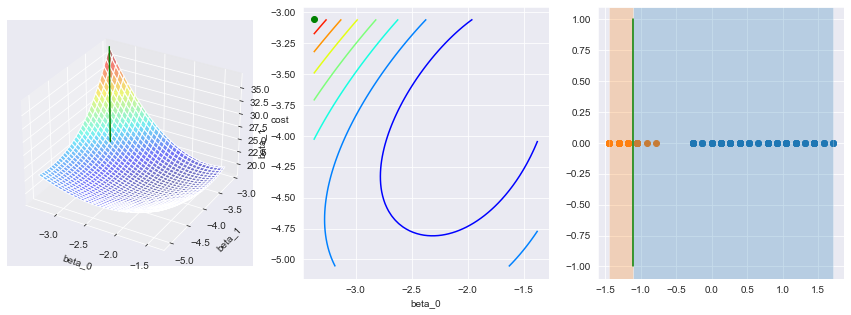

In [443]:
plot_gradient_descent(bbeta_0, bbeta_1, X_norm, y, bbeta_0_deltas[:1], bbeta_1_deltas[:1], get_model=get_linear_model)
plt.savefig(os.path.join(out_dir, 'gradient_descent_step_0.png'))
plt.show()

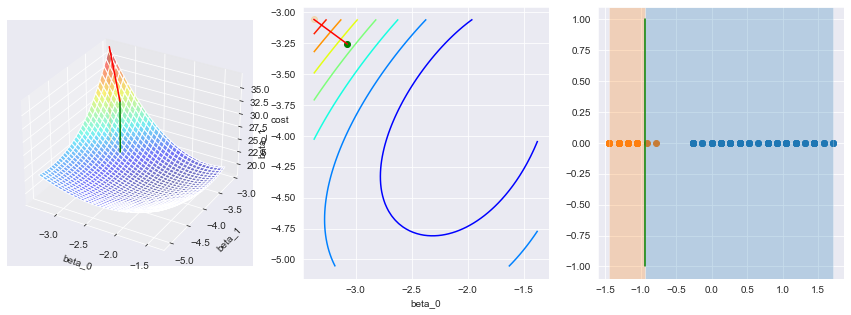

In [444]:
plot_gradient_descent(bbeta_0, bbeta_1, X_norm, y, bbeta_0_deltas[:2], bbeta_1_deltas[:2], get_model=get_linear_model)
plt.savefig(os.path.join(out_dir, 'gradient_descent_step_1.png'), transparent=False)
plt.show()

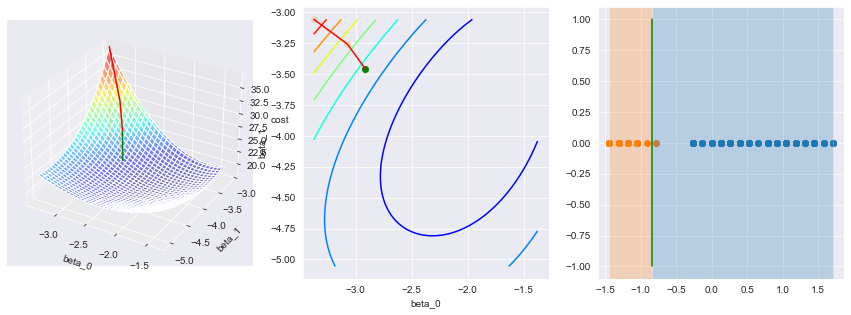

In [445]:
plot_gradient_descent(bbeta_0, bbeta_1, X_norm, y, bbeta_0_deltas[:3], bbeta_1_deltas[:3], get_model=get_linear_model)
plt.savefig(os.path.join(out_dir, 'gradient_descent_step_2.png'))
plt.show()

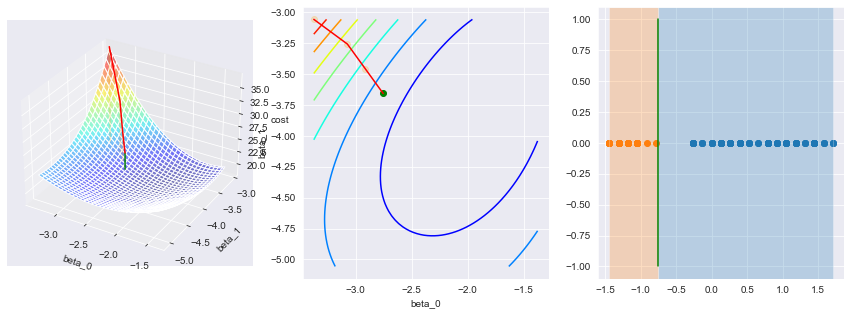

In [446]:
plot_gradient_descent(bbeta_0, bbeta_1, X_norm, y, bbeta_0_deltas[:4], bbeta_1_deltas[:4], get_model=get_linear_model)
plt.savefig(os.path.join(out_dir, 'gradient_descent_step_3.png'))
plt.show()

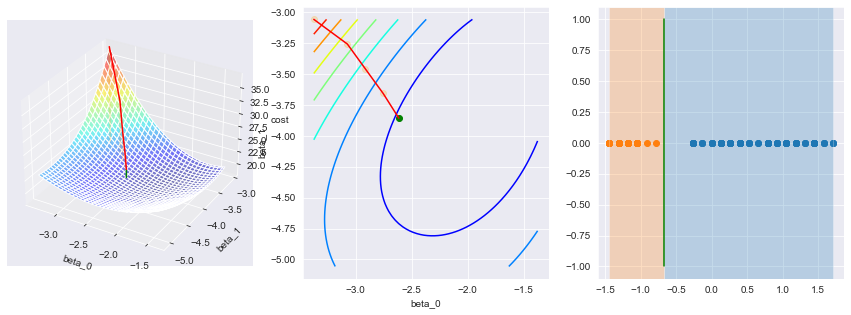

In [447]:
plot_gradient_descent(bbeta_0, bbeta_1, X_norm, y, bbeta_0_deltas[:5], bbeta_1_deltas[:5], get_model=get_linear_model)
plt.savefig(os.path.join(out_dir, 'gradient_descent_step_4.png'))
plt.show()

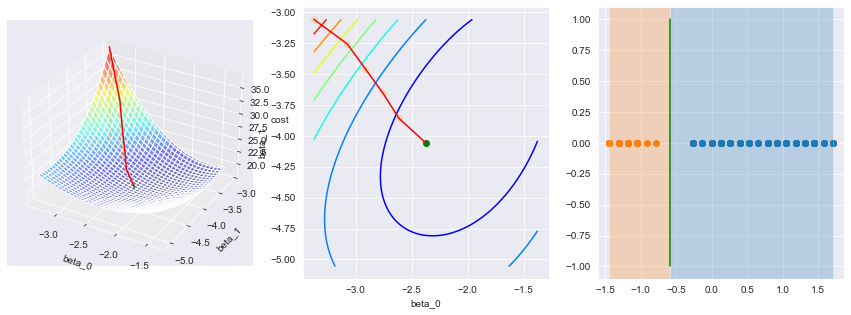

In [448]:
plot_gradient_descent(bbeta_0, bbeta_1, X_norm, y, bbeta_0_deltas, bbeta_1_deltas, get_model=get_linear_model)
plt.savefig(os.path.join(out_dir, 'gradient_descent_step_5.png'))
plt.show()

In [455]:
import imageio

filenames = list(map(lambda i: os.path.join(out_dir, f"gradient_descent_step_{i}.png"), range(1, 6)))

# build gif
print("Build GIF...")
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
images.append(imageio.imread(filenames[-1])) # Add last frame twice
imageio.mimsave(os.path.join(out_dir, 'gradient_descent.gif'), images, duration = 0.5)

Build GIF...


/var/folders/7d/vvm6spgd0k97dhyt65d21k600000gn/T/ipykernel_66113/434456333.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
/var/folders/7d/vvm6spgd0k97dhyt65d21k600000gn/T/ipykernel_66113/434456333.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filenames[-1])) # Add last frame twice
